In [1]:
# Version 1.4 of tutorial: V.A. Moss, based on tutorial from M.A. Brentjens 08/08/2017

import os
import sys
import time
import datetime
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Nice fonts (but do not play nice with Windows)
#rc('text', usetex=True) 
#rc('font',**{'family':'serif','serif':['serif'],'size':12})

from scipy import ndimage

from lofarantpos.db import LofarAntennaDatabase

In [2]:
start1 = time.time()

In [3]:
assert(sys.version_info.major + 0.1*sys.version_info.minor >= 3.6)

In [4]:
def sb_from_freq(freq, clock=200e6):
    """Convert subband number to central frequency"""
    chan = 0.5 * clock/512.
    sb = round(freq / chan)
    return int(sb)

def freq_from_sb(sb, clock=200e6):
    """Convert central frequency to subband number"""
    chan = 0.5 * clock/512.
    freq = (sb * chan)
    return freq

In [5]:
def read_rotations(rotationfilename):
    """Read station rotations"""
    rotdict = {}
    with open('stationrotations.txt', 'r') as rots:
        for line in rots:
            if line.startswith('station'):
                continue
            station_name, rotation_str = line.split()
            rotdict[station_name] = float(rotation_str)
    return rotdict

In [6]:
rotdict = read_rotations("stationrotations.txt")

In [7]:
# Read all available .dat files
data_dir = "./"
print(f"Searching for available files in {data_dir}")
files = glob.glob(data_dir + "/*.dat")
for file_index, filename in enumerate(files):
    print(f"{file_index}: {filename}")

Searching for available files in ./
0: ./20170720_095816_mode_3_xst_sb297.dat


In [8]:
# Select a file
cubefile = files[0]

print("File selected:", cubefile)

File selected: ./20170720_095816_mode_3_xst_sb297.dat


In [9]:
# Initialisation parameters
# Modified to match output from M. Mancini script
cubename = os.path.basename(cubefile)
station = 'DE603LBA'
stype = 'intl'

# Make directory for results
# Note... this won't work for windows...
try:
    os.mkdir('results')
except FileExistsError:
    print("results directory already exists...\n")

# Distill metadata from filename
obsdatestr, obstime, _, stationtype, _, subbandname = cubename.rstrip(".dat").split("_")
subband = int(subbandname[2:])
    
# Needed for NL stations: inner (mode 3/4), outer (mode 1/2), (sparse tbd)
# Should be set to 'inner' if station type = 'intl'
if stationtype in ('1', '2'):
    atype == 'outer'
elif stationtype in ('3', '4'):
    atype = 'inner'
else:
    raise Exception("Unexpected mode: ", stationtype)

# Get the data
fname = f"{obsdatestr}_{obstime}_{station}_SB{subband}"

im_x, im_y = 101, 101
freq = freq_from_sb(subband)

# Which slice in time to visualise
timestep = 0

# Calculate start time
starttime = datetime.datetime.strptime(obstime, '%H%M%S')

# For ground imaging
dims = np.array([-150, 150, -150, 150]) # metres
height = 1.5 # metres

# Confirm the data has been read correctly
print(f"""Filename: {cubename}
Station: {station}
Station type: {stype}
Array type: {atype}
Subband: {subband}
Timestep: {timestep}
Save title: {fname}
Sky image size: {im_x:d} x {im_y:d}
Ground image size: {dims[1]-dims[0]:d} x {dims[3]-dims[2]:d} m 
Ground height: {height} m
""")

results directory already exists...

Filename: 20170720_095816_mode_3_xst_sb297.dat
Station: DE603LBA
Station type: intl
Array type: inner
Subband: 297
Timestep: 0
Save title: 20170720_095816_DE603LBA_SB297
Sky image size: 101 x 101
Ground image size: 300 x 300 m 
Ground height: 1.5 m



In [10]:
def find_caltable(field_name, rcu_mode, config_dir='caltables'):
    """
    Find the file of a caltable.
    
    **Parameters**
    
    field_name : string
        The name of the antenna field, for example 'DE602LBA'

    rcu_mode : integer
        The receiver mode for which the calibration table is
        requested. An integer from 1 to 7 inclusive.

    config_dir : string
        Root directory under which station information is stored in
        subdirectories DE602C/etc/, RS106/etc/, ...
    
    **Returns**
    
    filename if it exists, None if nothing found
    """
    station, field = field_name[0:5].upper(), field_name[5:].upper()
    station_number = station[2:5]

    # Map to the correct file depending on the RCU mode
    if rcu_mode == 'outer' and 'LBA' in field_name:
        filename = os.path.join(config_dir, f"CalTable-{station_number}-LBA_OUTER-10_90.dat")
    elif rcu_mode == 'inner' and 'LBA' in field_name:
        filename = os.path.join(config_dir, f"CalTable-{station_number}-LBA_INNER-10_90.dat")
    else:
        filename = os.path.join(config_dir, f"CalTable_{station_number}_mode{rcu_mode}.dat")

    if os.path.exists(filename):
        return filename

    # If the original folder structure is kept
    if rcu_mode == 'outer' and 'LBA' in field_name:
        filename = os.path.join(config_dir, f"{station}/CalTable-{station_number}-LBA_OUTER-10_90.dat")
    elif rcu_mode == 'inner' and 'LBA' in field_name:
        filename = os.path.join(config_dir, f"{station}/CalTable-{station_number}-LBA_INNER-10_90.dat")
    else:
        filename = os.path.join(config_dir, f"{station}/CalTable_{station_number}_mode{rcu_mode}.dat")
            
    if os.path.exists(filename):
        return filename
    else:
        return None

In [11]:
# Read in calibration tables, by M. Brentjens (integrated 09/10/2017)
def read_caltable(filename, num_subbands = 512):
    """
    Reads a station's calibration table.

    **Parameters**

    filename: string
        Filename with the caltable

    **Returns**

    A tuple containing a list of strings representing the header
    lines, and a 2D numpy.array of complex numbers representing the
    station gain coefficients.
    """
    infile = open(filename, 'rb')
        
    header_lines = []

    try: 
        while True:
            header_lines.append(infile.readline().decode('utf8'))
            if 'HeaderStop' in header_lines[-1]:
                break
    except UnicodeDecodeError:
        # No header; close and open again
        infile.close()
        infile = open(filename, 'rb')

    caldata  = np.fromfile(infile, dtype=np.complex128)
    num_rcus = len(caldata)//num_subbands

    infile.close()

    return (header_lines, caldata.reshape((num_subbands, num_rcus)))

In [12]:
def sky_imager(visibilities, baselines, freq, im_x, im_y):
    """Do a Fourier transform for sky imaging"""
    img = np.zeros([im_y, im_x], dtype=np.float32)
    for m_ix, m in enumerate(np.linspace(-1, 1, im_x)):
        for l_ix,l in enumerate(np.linspace(1, -1, im_y)):
            n = np.sqrt(1 - l**2 - m**2)
            img[m_ix,l_ix] = np.mean(visibilities *
                                     np.exp(-2j * np.pi * freq *
                                            (baselines[:,:,0] * l + baselines[:,:,1] * m)/299792458.0))
    return img

def ground_imager(visibilities, baselines, freq, im_x, im_y, dims, station_pqr, height=1.5):
    """Do a Fourier transform for ground imaging"""
    img = np.zeros([im_y, im_x], dtype=np.float32)

    for q_ix, q in enumerate(np.linspace(dims[2], dims[3], im_y)):
        for p_ix, p in enumerate(np.linspace(dims[0], dims[1], im_x)):
            r = height
            pqr = np.array([p, q, r], dtype=np.float32)
            antdist = np.linalg.norm(station_pqr - pqr[np.newaxis, :], axis=1)    
            groundbase = np.zeros([len(station_pqr),len(station_pqr)], dtype='float32')
            for i in range(0,len(station_pqr)):
                groundbase[i] = antdist[i] - antdist[:]
            # Note: this is RFI integration second - normal second, to take out interference
            img[q_ix,p_ix] = np.mean(visibilities*np.exp(-2j*np.pi*freq*(-groundbase)/299792458.0))
    return img

In [13]:
# Function from Michiel: # of RCUs per station 
def rcus_in_station(station_type):
    """
    Returns the number of RCUs in a station, given its type.

    **Parameters**

    station_type : string
        The kind of station that produced the correlation. Choose one
        of 'core', 'remote', 'intl'.
    """
    return {'core': 96, 'remote': 96, 'intl': 192}[station_type]

In [14]:
# Function from Michiel to read in an ACM binary data cube
def read_acm_cube(filename, station_type):
    """
    **Parameters** 

    filename : string
        The file containing the array correlation matrix.

    station_type : string
        The kind of station that produced the correlation. Choose one
        of 'core', 'remote', 'intl'.

    **Returns**

    A 3D cube of complex numbers, where the indices are [time slots, rcu, rcu].

    **Examples**

    >>> cube = read_acm_cube('20170720_095816_xst.dat', 'intl')
    >>> cube.shape
    (29, 192, 192)
    """
    num_rcu    = rcus_in_station(station_type)
    data       = np.fromfile(filename, dtype=np.complex128)
    time_slots = int(len(data) / num_rcu / num_rcu)
    return data.reshape((time_slots, num_rcu, num_rcu))

In [15]:
# Read cube
cube = read_acm_cube(cubefile, stype)

In [16]:
# Print shape of cube
cube.shape, cube.dtype

((29, 192, 192), dtype('complex128'))

In [17]:
find_caltable(station, rcu_mode = atype)

'caltables/CalTable-603-LBA_INNER-10_90.dat'

In [18]:
# Apply calibration 

caltable_filename = find_caltable(station, rcu_mode=atype, config_dir="caltables")

if caltable_filename is None:
    print('No calibration table found... cube remains uncalibrated!')
else:
    cal_header, cal_data = read_caltable(caltable_filename)
    print(''.join(cal_header))
    rcu_gains = cal_data[subband, :]
    rcu_gains = np.array(rcu_gains, dtype=np.complex64)
    gain_matrix = rcu_gains[np.newaxis, :] * np.conj(rcu_gains[:, np.newaxis])
    cube = cube / gain_matrix

HeaderStart
CalTableHeader.Observation.Station = DE603
CalTableHeader.Observation.Mode = 3
CalTableHeader.Observation.AntennaSet = LBA_INNER
CalTableHeader.Observation.Band = 10_90
CalTableHeader.Observation.Source = CasA, CygA, VirA, TauA, Sun
CalTableHeader.Observation.Date = 201612271045
CalTableHeader.Calibration.Version = 0
CalTableHeader.Calibration.Name = L.Cerrigone
CalTableHeader.Calibration.Date = 20170403
CalTableHeader.Calibration.PPSDelay = [12 15 23 30 14 19 24 33 14 16 25 30 11 16 22 29 10 11 20 24 11 17 21 28 10 15 20 29 9 14 20 29 11 16 24 30 13 17 22 33 13 19 24 33 12 15 22 30 9 14 21 24 9 14 20 26 10 15 21 25 14 16 23 30 14 19 24 29 13 18 24 28 11 14 20 24 13 16 24 29 12 16 23 29 12 17 24 30 9 13 20 23 10 15 22 28 ]
CalTableHeader.Comment = Manually flagged: several
HeaderStop



In [19]:
# Split into the XX and YY polarisations (RCUs)
# This needs to be modified in future for LBA sparse 
cube_xx = cube[:, 0::2, 0::2]
cube_yy = cube[:, 1::2, 1::2]
visibilities_all = cube_xx + cube_yy

# Stokes I for specified timestep
visibilities = visibilities_all[timestep]

In [20]:
# Check the resulting cubes have half the size
cube_xx.shape, cube_yy.shape, visibilities.shape, visibilities.dtype

((29, 96, 96), (29, 96, 96), (96, 96), dtype('complex128'))

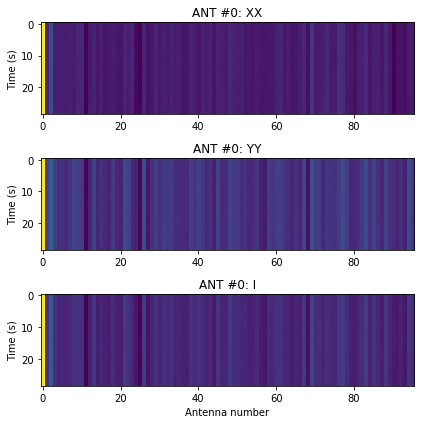

In [21]:
# Check how the various antennas/polarisation look with time
fig1, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(6,6))

ax0.imshow(cube_xx[:, 0, :].real, aspect='auto')
ax0.set_ylabel('Time (s)')
ax0.set_title('ANT #0: XX')
ax1.imshow(cube_yy[:,0,:].real,aspect='auto')
ax1.set_title('ANT #0: YY')
ax1.set_ylabel('Time (s)')
ax2.imshow(visibilities_all[:,0,:].real,aspect='auto')
ax2.set_title('ANT #0: I')
ax2.set_xlabel('Antenna number')
ax2.set_ylabel('Time (s)')
plt.tight_layout()

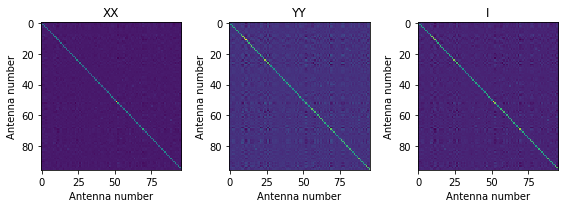

In [22]:
# Check how the correlations look
fig1, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(8,3))

ax0.imshow(cube_xx[0,:,:].real, aspect='auto')
ax0.set_xlabel('Antenna number')
ax0.set_ylabel('Antenna number')
ax0.set_title('XX')
ax1.imshow(cube_yy[0,:,:].real, aspect='auto')
ax1.set_title('YY')
ax1.set_xlabel('Antenna number')
ax1.set_ylabel('Antenna number')
ax2.imshow(visibilities.real, aspect='auto')
ax2.set_title('I')
ax2.set_xlabel('Antenna number')
ax2.set_ylabel('Antenna number')
plt.tight_layout()

In [23]:
# Setup the database
db = LofarAntennaDatabase()

In [24]:
# Get the PQR positions for an individual station
station_pqr = db.antenna_pqr(station)

# Exception: for Dutch stations (sparse not yet accommodated)
if (stype == 'core' or stype == 'remote') and atype == 'inner':
    station_pqr = station_pqr[0:48,:]
elif (stype == 'core' or stype == 'remote') and atype == 'outer':
    station_pqr = station_pqr[48:,:]
    
station_pqr = station_pqr.astype('float32')

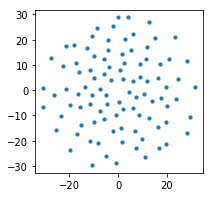

In [25]:
# Plot these positions (see layout of LBA)
plt.figure(figsize=(3,3))
plt.scatter(station_pqr[:,0],station_pqr[:,1],s=10);

In [26]:
# Check the shape of the PQR cube
station_pqr.shape

(96, 3)

In [27]:
# For every antenna, calculate the "distance" between it and every other antenna
baselines = station_pqr[:, np.newaxis, :] - station_pqr[np.newaxis, :, :]

In [28]:
# Check the shape of the baselines array
baselines.shape

(96, 96, 3)

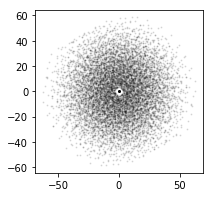

In [29]:
# Make a plot of the baselines contents (only U-V, not W)
# This gives the instantaneous U-V coverage of the LBA station
plt.figure(figsize=(3,3))
plt.scatter(baselines[:,:,0], baselines[:,:,1], facecolor='k', edgecolor='k', s=1, alpha=0.1);

In [30]:
# Account for the rotation
rotation = rotdict[station]
print ('Rotation for %s: %.2f deg' % (station,rotation))

Rotation for DE603LBA: -3.80 deg


In [31]:
# Make a sky image, by numerically Fourier-transforming from visibilities to image plane
from matplotlib.patches import Circle

# Fourier transform, and account for the rotation (rotation is positive in this space)
# visibilities = cube_xx[2,:,:]
img = sky_imager(visibilities, baselines, freq, im_x, im_y)
img = ndimage.interpolation.rotate(img, rotation, reshape=False, mode='nearest')

/anaconda/envs/school19/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  
/anaconda/envs/school19/lib/python3.6/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


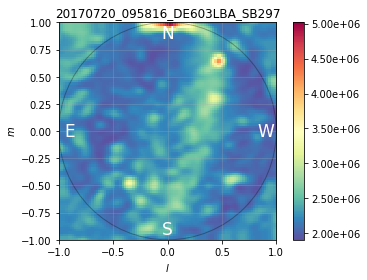

In [32]:
# Plot the resulting sky image
fig, ax = plt.subplots(1)
cax = ax.imshow(img, origin='lower', cmap=cm.Spectral_r, extent=(-1,1,-1,1))
fig.colorbar(cax, format='%.2e')

# This circle should be OS-independent...
circle1 = Circle((0,0), 1.0, edgecolor='k', fill=False, alpha=0.3)
ax.add_artist(circle1)

# Labels
ax.set_xlabel('$l$')
ax.set_ylabel('$m$')
#ax.set_title('\_'.join(fname.split('_'))) # Only for fancy fonts
ax.set_title(fname)

# Plot the compass directions
ax.text(0.9, 0, 'W', horizontalalignment='center', verticalalignment='center', color='w', fontsize=17)
ax.text(-0.9, 0, 'E', horizontalalignment='center', verticalalignment='center', color='w', fontsize=17)
ax.text(0, 0.9, 'N', horizontalalignment='center', verticalalignment='center', color='w', fontsize=17)
ax.text(0, -0.9, 'S', horizontalalignment='center', verticalalignment='center', color='w', fontsize=17)

ax.grid(True, alpha=0.3)

plt.savefig(f'results/{fname}_sky_calibrated.png', bbox_inches='tight', dpi=200)

/anaconda/envs/school19/lib/python3.6/site-packages/ipykernel_launcher.py:25: ComplexWarning: Casting complex values to real discards the imaginary part


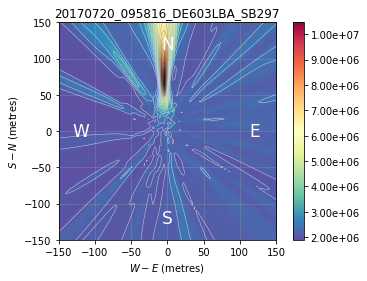

In [33]:
# Make a ground image, by numerically Fourier-transforming from visibilities to ground plane

# NOTE: dims currently must be centered on (0,0) for the rotation to work! 
#dims = np.array([-250,250,-250,250])
ratio = 0.5 # how many pixels per metre, default is 0.5 pixel/metre
im_x, im_y = int(ratio*(abs(dims[1]-dims[0]))),int(ratio*(abs(dims[3]-dims[2])))
dims2 = dims * 1.5 # image further to account for rotation post-transform

# Fourier transform (rotation is negative in this space)
img = ground_imager(visibilities, baselines, freq, im_x, im_y, dims2, station_pqr, height=1.5)
img_rotated = ndimage.interpolation.rotate(img, -rotation, reshape=False, mode='nearest')

# Plot the resulting image
fig, ax = plt.subplots()
cax = ax.imshow(img_rotated, origin='lower', cmap=cm.Spectral_r, extent=dims2)
fig.colorbar(cax, format='%.2e')
ax.set_xlabel('$W-E$ (metres)')
ax.set_ylabel('$S-N$ (metres)')
#title('\_'.join(fname.split('_'))) # Only for fancy fonts
ax.set_title(fname)

# Custom range for dims (set to whatever is needed to zoom)
#dims = np.array([-150,0,-100,50]) # metres

# Change limits to match the original specified dimensions
ax.set_xlim(dims[0],dims[1])
ax.set_ylim(dims[2],dims[3])

# Place the NSEW coordinate directions
ax.text(0.9, 0.5, 'E', color='w', fontsize=17, transform=ax.transAxes, horizontalalignment='center', verticalalignment='center')
ax.text(0.1, 0.5, 'W', color='w', fontsize=17, transform=ax.transAxes, horizontalalignment='center', verticalalignment='center')
ax.text(0.5, 0.9, 'N', color='w', fontsize=17, transform=ax.transAxes, horizontalalignment='center', verticalalignment='center')
ax.text(0.5, 0.1, 'S', color='w', fontsize=17, transform=ax.transAxes, horizontalalignment='center', verticalalignment='center')

ax.contour(img_rotated, 30, origin='lower', cmap=cm.Greys, extent=dims2, linewidths=0.5, alpha=0.7)
ax.grid(True, alpha=0.3)
plt.savefig(f"results/{fname}_nearfield_calibrated.png", bbox_inches='tight', dpi=200)

In [34]:
# Check total time to run
end1 = time.time()
print ('Time elapsed: %.2f s' % (end1-start1))

Time elapsed: 26.62 s


In [35]:
import lofargeotiff

In [36]:
obsdate = datetime.datetime.strptime(obsdatestr + ":" + obstime, '%Y%m%d:%H%M%S')

In [37]:
tags = {"datafile": cubefile,
        "generated_with": "LOFAR LBA imaging tutorial v1.4",
        "caltable": caltable_filename}
lofargeotiff.write_geotiff(img, f"results/{fname}_nearfield_calibrated.tiff",
                           (dims[0], dims[2]), (dims[1], dims[3]), stationname=station,
                           obsdate=obsdate)

In [39]:
import folium

In [42]:
lon_center, lat_center, _ = lofargeotiff.pqr_to_longlatheight([0, 0, 0], station)
lon_min, lat_min, _ = lofargeotiff.pqr_to_longlatheight([dims[0], dims[2], 0], station)
lon_max, lat_max, _ = lofargeotiff.pqr_to_longlatheight([dims[1], dims[3], 0], station)

In [43]:
m = folium.Map(location=[lat_center, lon_center], zoom_start=17,
               tiles='http://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/MapServer/tile/{z}/{y}/{x}',
               attr='ESRI')
folium.TileLayer(tiles="OpenStreetMap").add_to(m)

folium.raster_layers.ImageOverlay(
   name='Near field image',
   image=img_rotated,
   bounds=[[lat_min, lon_min], [lat_max, lon_max]],
   opacity=0.6,
   interactive=True,
   cross_origin=False,
   zindex=1,
   origin='lower'
).add_to(m)

folium.LayerControl().add_to(m)
m